# Titanic Kaggle Competition

## Data Analysis
The first phase is to analize the dataset, in order to discover some information about available data.

Context of dataset:
- On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew (32% survival rate).
- There were not enough lifeboats for the passengers and crew.
- Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In [1]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

Let's take a look to features name:

In [3]:
train.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

Features type:
- Categorical:
    - Nominal:
        - Survived
        - Sex
        - Embarked
    - Ordinal:
        - Pclass
- Numerical:
    - Continuos:
        - Age
        - Fare
    - Discrete:
        - SibSp
        - Parch

We need to know if there are some null values, in order to correct or drop some features.

In [4]:
print(train.info())
print("-"*50)
print(test.info())
print("-"*50)
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket      

- Cabin feature is mostly incomplete both in training and test dataset. This feature may be useful, as there may be a correlation between cabin position and survival. But there may not be sufficient information to complete it correctly and cabin position is probably correlate to fare. So it may be dropped.
- There may not be a correlation between Ticket and survival.
- We can complete the Embarked feature (only 2 null values).
- We have to complete Age feature as we know it is correlated to survival.

In [5]:
train[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [6]:
train[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [7]:
train[["SibSp", "Survived"]].groupby(["SibSp"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [8]:
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


This confirm there are a correlation between Pclass/Sex and Survived.
There may also be a correlation between SibSp/Parch and Survived, but there are some values with 0 correlation.

To complete Age feature we may consider Title of people, rather than put average age. So we need to add this new feature, extrapolating it from Name feature. Extract title may be useful to obtain additional information about social stuatus too.

## Data wragling

So resume what we discover from data analysis:
- We must complete Age feature
- We should extrapolate Title feature from Name
- There are a missing value in Fare, two missing values in Embarked and a lot of missing values in Cabin.

First of all, we extract and removing the Survived feature and combine the two set, to engineer new features.

In [9]:
survived = train['Survived']
train.drop(['Survived'], 1, inplace=True)
titanic = train.append(test)
titanic.reset_index(inplace=True)
titanic.drop(['index', 'PassengerId'], inplace=True, axis=1)

Now we can extract the passenger title and maps the titles to categories.

In [10]:
titanic["Title"] = titanic["Name"].map(lambda name:name.split(',')[1].split('.')[0].strip())

Let's see what are the different titles

In [11]:
titanic.groupby(['Title'], as_index=False).size()

Title
Capt              1
Col               4
Don               1
Dona              1
Dr                8
Jonkheer          1
Lady              1
Major             2
Master           61
Miss            260
Mlle              2
Mme               1
Mr              757
Mrs             197
Ms                2
Rev               8
Sir               1
the Countess      1
dtype: int64

There are titles with just few people, so we can combined them in a single category.

In [12]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Dona": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}
titanic['Title'] = titanic['Title'].map(Title_Dictionary)

Now we can drop Name feature.

In [13]:
titanic.drop("Name", axis=1, inplace=True)

Let's see mean age of these categories (first 891 rows, to avoid data leakage):

In [14]:
grouped_mean_age = titanic[["Title", "Age"]].iloc[:891].groupby(['Title'], as_index=False).mean()
grouped_mean_age = grouped_mean_age.reset_index()[["Title", "Age"]]
grouped_mean_age

,Title,Age
0,Master,4.574167
1,Miss,21.804054
2,Mr,32.368090
3,Mrs,35.718182
4,Officer,46.705882
5,Royalty,41.600000


We use this data to fill missing ages.

In [15]:
def fill_age(row):
    condition = (grouped_mean_age["Title"] == row["Title"])
    return grouped_mean_age[condition]["Age"].values[0]

def process_age():
    titanic['Age'] = titanic.apply(
        lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], 
        axis=1
    )
    return titanic

In [16]:
titanic = process_age()

In [17]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
Pclass      1309 non-null int64
Sex         1309 non-null object
Age         1309 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Title       1309 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 102.3+ KB


We enconde the title values using a dummy encoding.

In [18]:
titles_dummies = pd.get_dummies(titanic["Title"], prefix="Title")
titanic = pd.concat([titanic, titles_dummies], axis=1)
titanic.drop("Title", axis=1, inplace=True)

In [19]:
titanic.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0


Now we replace missing values in Fare (with Fare mean) and Embarked (with the most frequent value). We encode Embarked values using a dummy encoding.

In [22]:
mean_fare = titanic.iloc[:891]["Fare"].mean()
titanic["Fare"].fillna(mean_fare, inplace=True)

In [33]:
mostfrq_embarked = titanic.iloc[:891]["Embarked"].mode()[0]
titanic["Embarked"].fillna(mostfrq_embarked, inplace=True)

In [37]:
embarked_dummies = pd.get_dummies(titanic["Embarked"], prefix="Embarked")
titanic = pd.concat([titanic, embarked_dummies], axis=1)
titanic.drop("Embarked", axis=1, inplace=True)

We drop Cabin feature, as it contains a lot of missed values (77,46%), and Ticket feature.

In [35]:
titanic.drop("Cabin", axis=1, inplace=True)

In [39]:
titanic.drop("Ticket", axis=1, inplace=True)

In [40]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
Pclass           1309 non-null int64
Sex              1309 non-null object
Age              1309 non-null float64
SibSp            1309 non-null int64
Parch            1309 non-null int64
Fare             1309 non-null float64
Title_Master     1309 non-null uint8
Title_Miss       1309 non-null uint8
Title_Mr         1309 non-null uint8
Title_Mrs        1309 non-null uint8
Title_Officer    1309 non-null uint8
Title_Royalty    1309 non-null uint8
Embarked_C       1309 non-null uint8
Embarked_Q       1309 non-null uint8
Embarked_S       1309 non-null uint8
dtypes: float64(2), int64(3), object(1), uint8(9)
memory usage: 72.9+ KB


So, there aren't any feature with missing values. Now we have to process some features:
- we maps Sex values to 0 (male) and 1 (female).
- we encode the values of Pclass using a dummy encoding.

In [41]:
titanic["Sex"] = titanic["Sex"].map({"male":0, "female":1})

In [42]:
pclass_dummies = pd.get_dummies(titanic["Pclass"], prefix="Pclass")
titanic = pd.concat([titanic, pclass_dummies], axis=1)
titanic.drop("Pclass", axis=1, inplace=True)

In [43]:
titanic.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,0,0,0,1,0,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,0,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,1,0,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,1,0,0,1


## Model training

Decision trees may be a good model to this problem. But to avoid problems afflicting Decision Trees, we'll be using Random Forests.

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [48]:
train = titanic.iloc[:891]
test = titanic.iloc[891:]
targets = survived

In [52]:
classifier = RandomForestClassifier(n_estimators=50, max_features="sqrt")
classifier = classifier.fit(train, targets)

In [53]:
features = pd.DataFrame()
features["feature"] = train.columns
features["importance"] = classifier.feature_importances_
features.sort_values(by=["importance"], ascending=True, inplace=True)
features.set_index("feature", inplace=True)

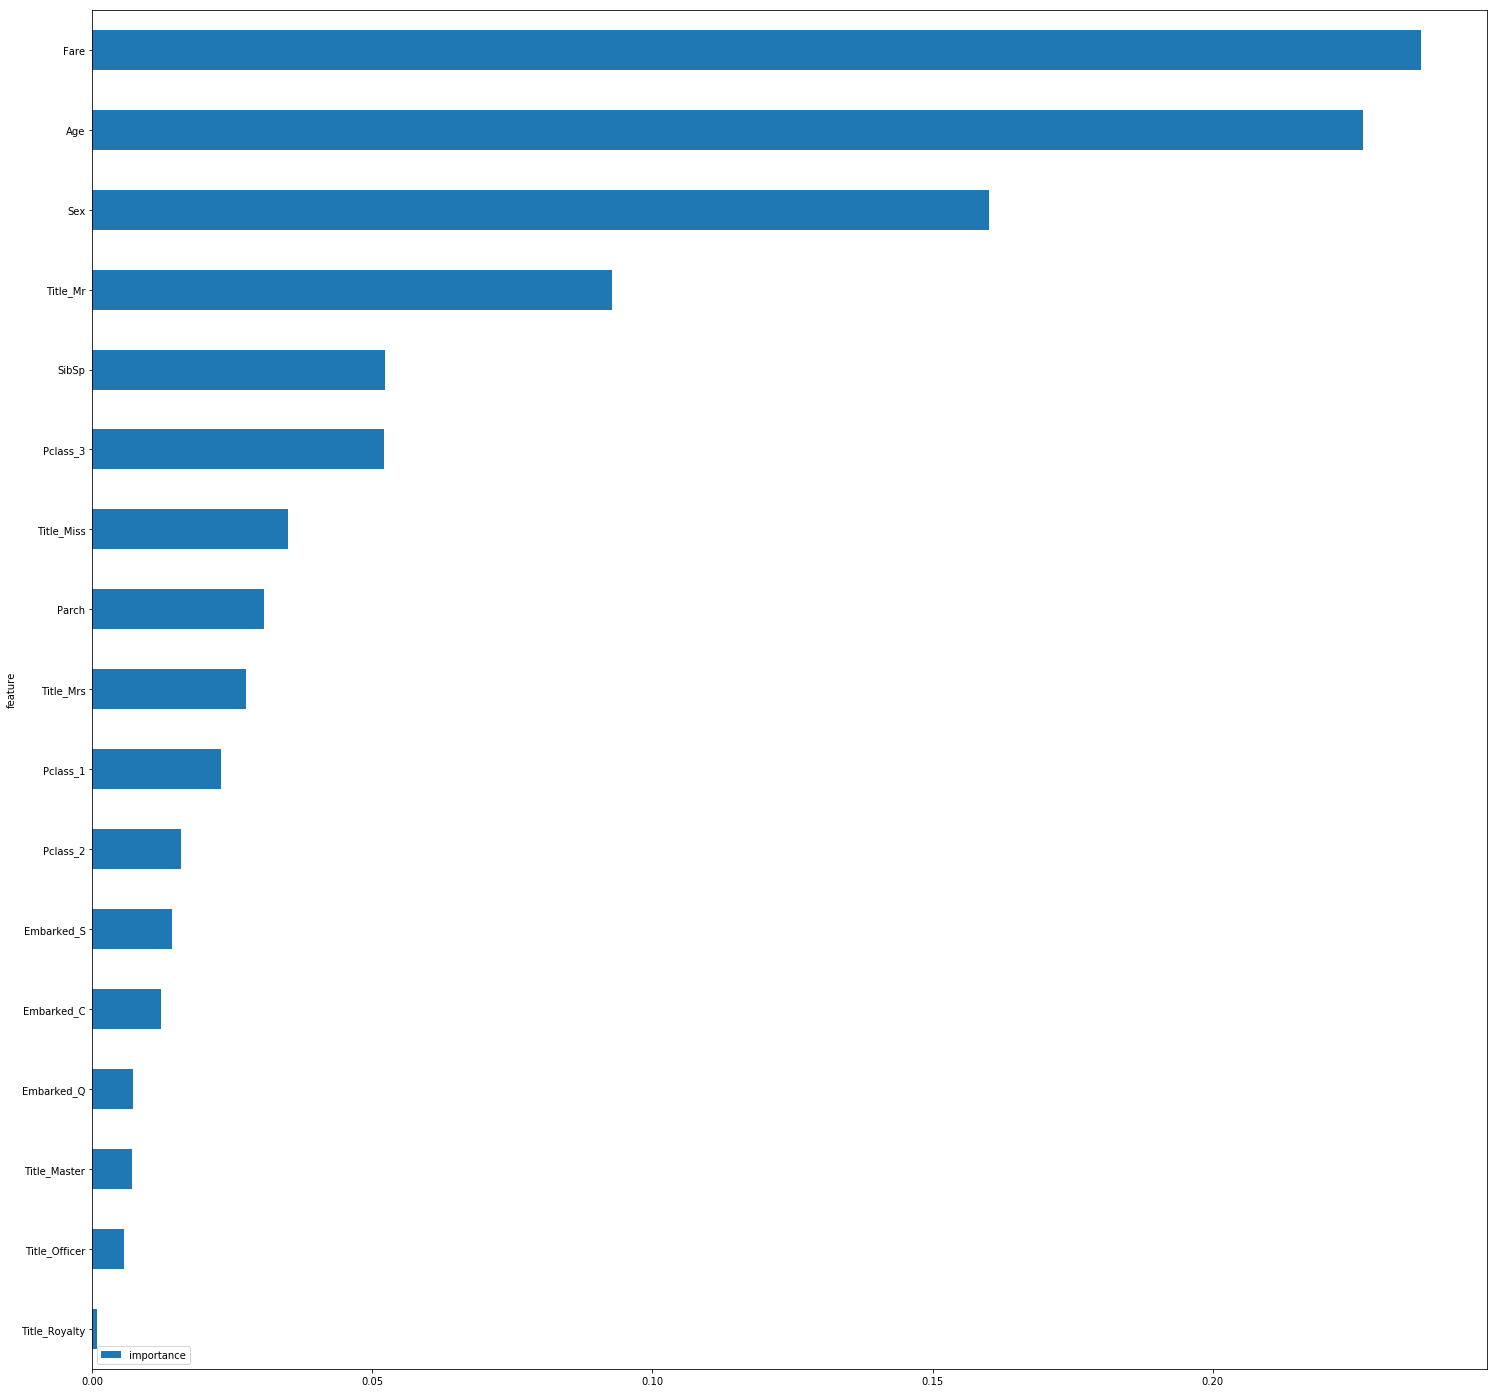

In [54]:
features.plot(kind="barh", figsize=(25,25))

In [58]:
model = SelectFromModel(classifier, prefit=True)
train_reduced = model.transform(train)
train_reduced.shape

(891, 4)

In [59]:
test_reduced = model.transform(test)
test_reduced.shape

(418, 4)

In [61]:
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

In [64]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('./data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('./predictions/predictions.csv', index=False)

# Conclusion

0,79904 score. 1489/10003 (top 15%) in Kaggle Leaderboard.